## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Error importing in API mode: ImportError("dlopen(/Users/wongpeiting/.pyenv/versions/3.13.9/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <B96A8100-FA7A-3EFC-8726-931D26646DE6> /Users/wongpeiting/.pyenv/versions/3.13.9/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [5]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Once you've found the variable or variables you want, you can plug them into this code under `variables`. 

In [6]:
%%R 

# the variable B01003_001 was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/

# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",     # population
                        total_units = "B25001_001",  # housing units
                        med_inc="B19013_001"         # median income
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

nyc_census_data


Simple feature collection with 6981 features and 5 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                       NAME    variable estimate
1  36081014700  Census Tract 147, Queens County, New York  population     2863
2  36081014700  Census Tract 147, Queens County, New York     med_inc    71815
3  36081014700  Census Tract 147, Queens County, New York total_units     1570
4  36047058400   Census Tract 584, Kings County, New York  population     3655
5  36047058400   Census Tract 584, Kings County, New York     med_inc    67315
6  36047058400   Census Tract 584, Kings County, New York total_units     1498
7  36061006900 Census Tract 69, New York County, New York  population     2450
8  36061006900 Census Tract 69, New York County, New York     med_inc   237500
9  36061006900 Census Tract 69, New York Co

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [7]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  # pivot from wide to long
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )

nyc_census_data

Simple feature collection with 2327 features and 8 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 9
   GEOID    NAME                   geometry population_estimate med_inc_estimate
   <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3608101… Cens… (((-73.9137 40.76548, -7…                2863            71815
 2 3604705… Cens… (((-73.96103 40.59616, -…                3655            67315
 3 3606100… Cens… (((-74.02064 40.73039, -…                2450           237500
 4 3604707… Cens… (((-73.93345 40.6257, -7…                2676           117857
 5 3604710… Cens… (((-73.90735 40.63083, -…                3004            76207
 6 3604705… Cens… (((-73.96279 40.72256, -…                1834           107410
 7 3600502… Cens… (((-73.92012 40.83759, -…                4030            37200
 8 3608104… Cens… (((-73

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

In this example, we create a column called `borough` by extracting the borough from the `NAME` column.

_(hint, I used GitHub Copilot -- a tool similar to ChatGPT -- to do this...see my prompt in the comments)_

In [8]:
%%R 

# Extract borough name from NAME by splitting strings like 
# "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim()
    )

### Step 5 | Example Plots

Let's practice with histograms

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: Removed 131 rows containing non-finite outside the scale range (`stat_bin()`). 
  


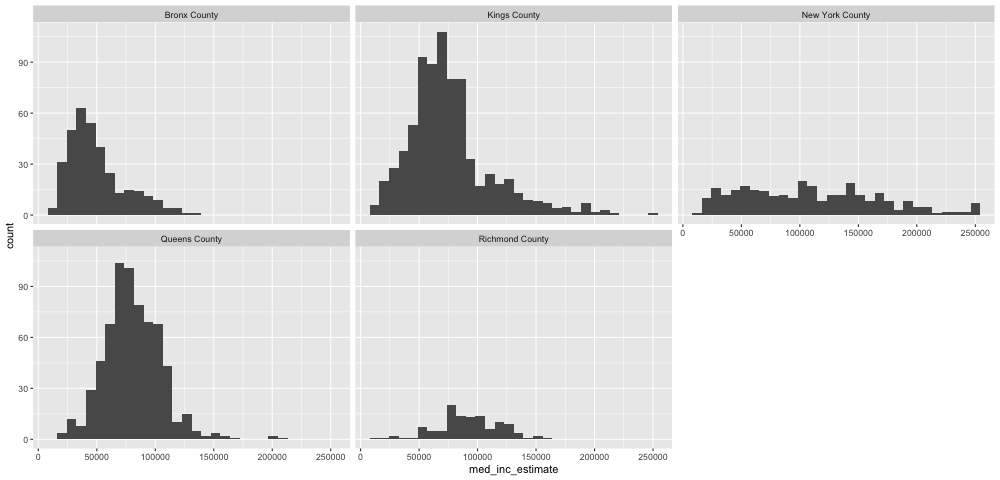

In [9]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=med_inc_estimate) +
    geom_histogram() + 
    facet_wrap(~borough) 

R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Removed 131 rows containing non-finite outside the scale range
(`stat_boxplot()`). 
  
R callback write-console: 2: Removed 131 rows containing missing values or values outside the scale range
(`geom_point()`). 
  


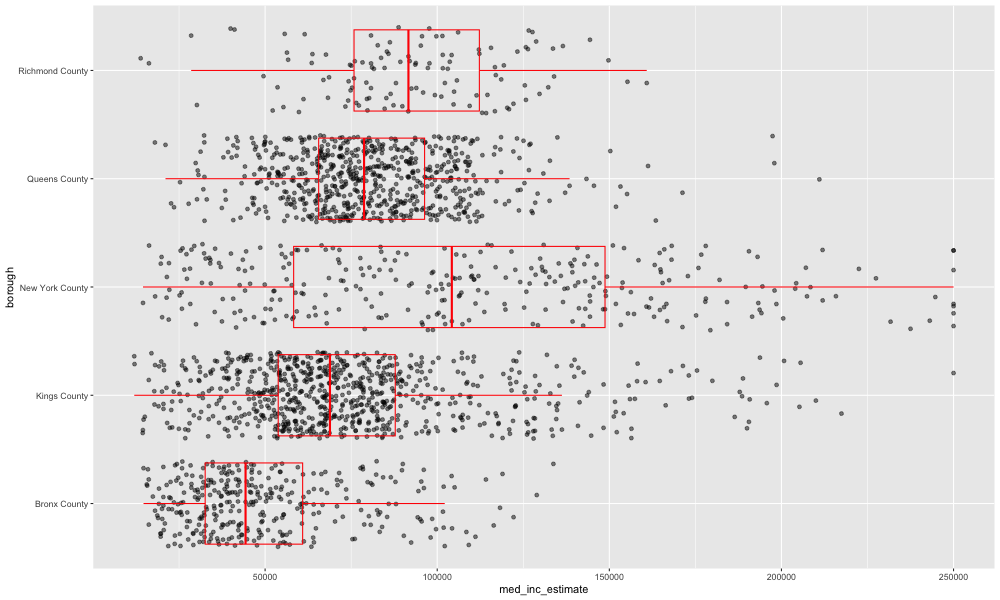

In [10]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=med_inc_estimate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

In [11]:
%%R 

library(tigris)

# remove water from the shapefiles
# https://walker-data.com/tidycensus/articles/spatial-data.html
nyc_census_data <- nyc_census_data %>% 
    erase_water()

To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.
Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


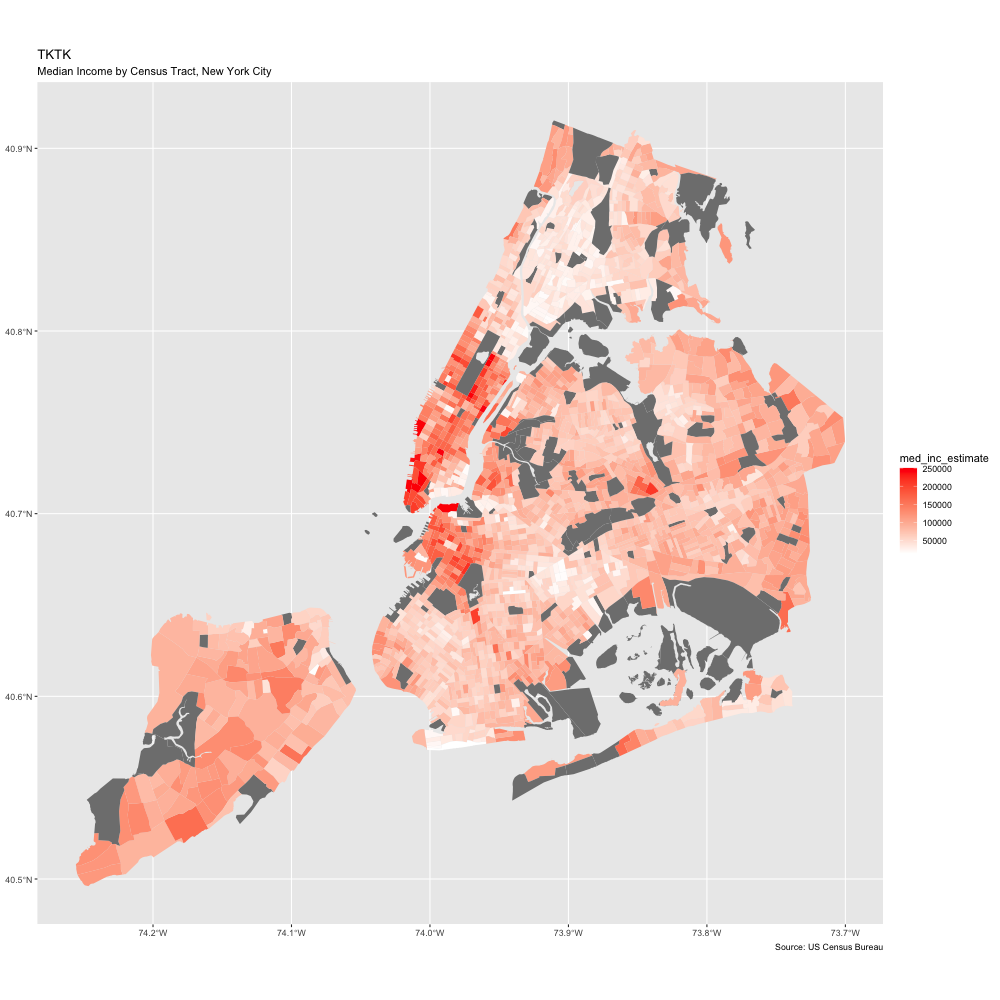

In [12]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = med_inc_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "TKTK",
    subtitle = "Median Income by Census Tract, New York City",
    caption = "Source: US Census Bureau"
  )


## Step 7 | Your Turn - Pick a different geography

- 👉 Here are the various [geographies you can use with tidycensus](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus). Try changing the analysis from the census tract level to the something more granular like `block group`. What do you notice that you didn't when looking at the tract-level data?

    **hint**: If you select block group, you may have to modify the code in **step 5** 
    > 
    > When you ask for **census tracts**, the NAME variable looks like this `Census Tract 147, Queens County, New York`
    >
    > The code in step 5 is currently set up to split on commas and take the second item (in this case `Queens County`).
    >
    > ```r
    >   nyc_census_data <- nyc_census_data %>% 
    >        mutate(
    >        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
    >    ) 
    >
    >    nyc_census_data
    >```
    >
    >But when you ask for data by **block group**, the `NAME` variable looks like this `Block Group 0, Census Tract 135.02, New York County, New York`. 
    >
    >So you will have to modify the code to extract the borough from the **block group** rather than the **census tract** name.

In [15]:
%%R 

# Get data at BLOCK GROUP level instead of tract
nyc_block_groups <- get_acs(
  geography = "block group",  # Changed from "tract"
  state = 'NY',
  county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
  variables = c(
    population = "B01003_001",
    total_units = "B25001_001",
    med_inc = "B19013_001"
  ), 
  year = 2021,
  survey = "acs5",
  geometry = TRUE
)

# Check what the NAME looks like for block groups
head(nyc_block_groups$NAME)

  |======================================================================| 100%
[1] "Block Group 2, Census Tract 934.01, Queens County, New York"  
[2] "Block Group 2, Census Tract 934.01, Queens County, New York"  
[3] "Block Group 2, Census Tract 934.01, Queens County, New York"  
[4] "Block Group 0, Census Tract 135.02, New York County, New York"
[5] "Block Group 0, Census Tract 135.02, New York County, New York"
[6] "Block Group 0, Census Tract 135.02, New York County, New York"


Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


In [16]:
%%R 

# Pivot to wide format
nyc_block_groups <- nyc_block_groups %>% 
  pivot_wider(
    names_from = variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )

# Extract borough - NOTE: for block groups, borough is the 3rd element, not 2nd
# Block group NAME: "Block Group 0, Census Tract 135.02, New York County, New York"
#                    [1]            [2]                   [3]              [4]
nyc_block_groups <- nyc_block_groups %>% 
  mutate(
    borough = str_split(NAME, ",") %>% map_chr(3) %>% str_trim()
  )

nyc_block_groups

Simple feature collection with 6807 features and 9 fields (with 49 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 6,807 × 10
   GEOID    NAME                   geometry population_estimate med_inc_estimate
 * <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3608109… Bloc… (((-73.844 40.57951, -73…                1183            82000
 2 3606101… Bloc… (((-74.00162 40.77455, -…                   0               NA
 3 3600505… Bloc… (((-73.79188 40.85522, -…                 887           118514
 4 3606101… Bloc… (((-73.95881 40.78086, -…                 984           205455
 5 3604703… Bloc… (((-73.94244 40.66673, -…                 612            85313
 6 3606100… Bloc… (((-74.00553 40.74582, -…                1508               NA
 7 3608100… Bloc… (((-73.86806 40.69118, -…                1932            78500
 8 3608501… Bloc… ((

In [17]:
%%R 

# Remove water areas
nyc_block_groups <- nyc_block_groups %>% 
  erase_water()

Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: Removed 8 rows containing missing values or values outside the scale range
(`geom_sf()`). 
  


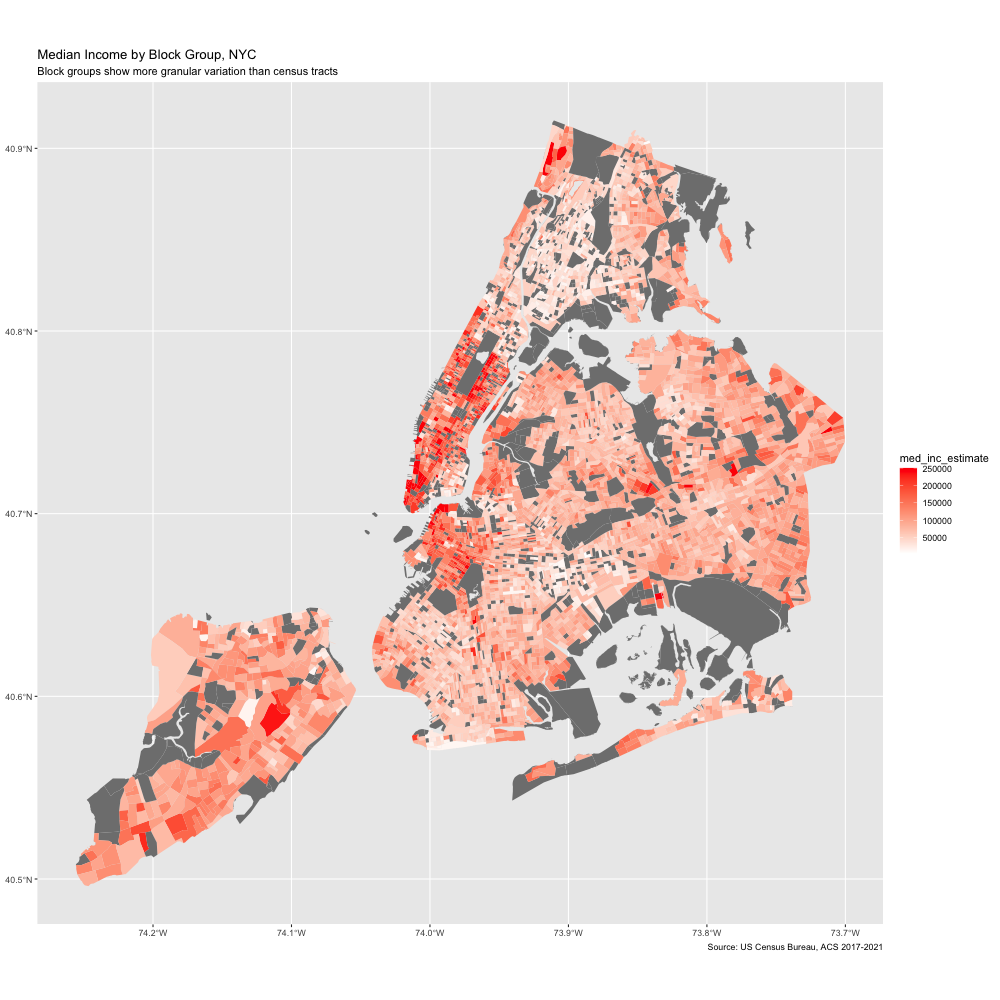

In [18]:
%%R -w 1000 -h 1000

# Map median income by block group
nyc_block_groups %>%
  ggplot(aes(fill = med_inc_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low = "white", high = "red") + 
  labs(
    title = "Median Income by Block Group, NYC",
    subtitle = "Block groups show more granular variation than census tracts",
    caption = "Source: US Census Bureau, ACS 2017-2021"
  )

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: Removed 1122 rows containing non-finite outside the scale range (`stat_bin()`). 
  


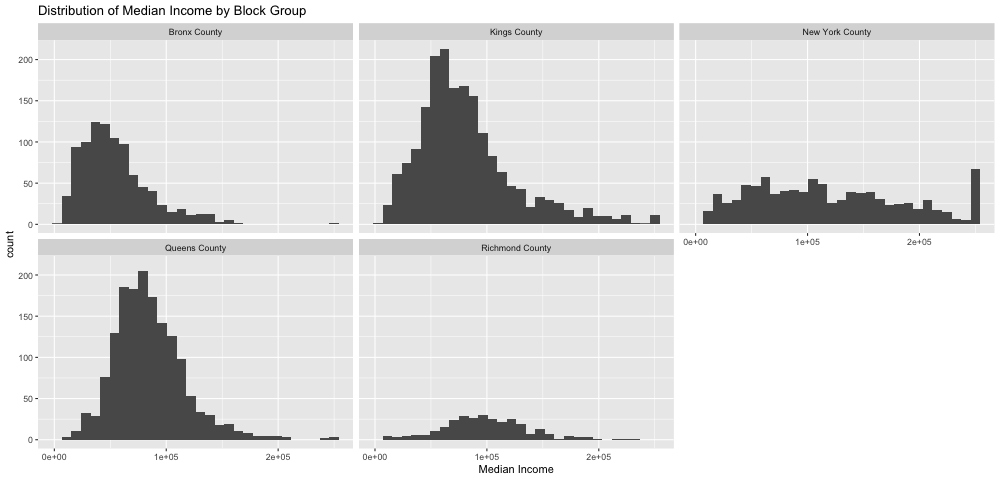

In [19]:
%%R -w 1000

# Histogram of median income by borough (block group level)
ggplot(nyc_block_groups) + 
  aes(x = med_inc_estimate) +
  geom_histogram() + 
  facet_wrap(~borough) +
  labs(
    title = "Distribution of Median Income by Block Group",
    x = "Median Income"
  )

In [21]:
# Answering Step 7's question:  >> What do you notice that you didn't when looking at the tract-level data?

# Block groups show more granular variation, so now we find that a particular block in Staten Island also has a high concentration of higher income dwellers. The tract-level map failed to highlight that area (which seems to be Richmond County Country Club Golf House), as being a higher-income area. The block-level data also allowed us to pinpoint the particular neighbourhoods in Riverdale up north with higher income dwellers.

## Step 8 | Your Turn - Explore: Pick a your own variable or variables and geography level


- 👉 Pick a different variable other than median income and re-run the notebook. Use [https://censusreporter.org/](https://censusreporter.org) figure out what variable or variables you'd like to explore and add them to the list in **step 2**. 

    
    *hint*: Remember, you can create new columns in **step 5** using `mutate`. For example, the following code would both split the census tract out of the NAME column, and also 

    ```r
    nyc_census_data <- nyc_census_data %>% 
        mutate(
            borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
            units_per_person = total_unitstotal_units_estimate / population_estimate
        ) 

    nyc_census_data
    ```



### Looking at data of unmarried women who had a birth

Using table B13014: Women 15 to 50 Years Who Had a Birth in the Past 12 Months by Marital Status and Educational Attainment

Source: https://censusreporter.org/tables/B13014/

In [43]:
%%R

# STEP 1: Explore B13014 table structure to find the RIGHT variables
# The table is: "Women 15-50 Who Had a Birth by Marital Status and Educational Attainment"

b13014_vars <- load_variables(2021, "acs5") %>%
  filter(str_detect(name, "B13014_"))

# Print with full width so we can see the complete labels
b13014_vars %>% 
  select(name, label) %>%
  print(n = 30, width = Inf)

# A tibble: 27 × 2
   name      
   <chr>     
 1 B13014_001
 2 B13014_002
 3 B13014_003
 4 B13014_004
 5 B13014_005
 6 B13014_006
 7 B13014_007
 8 B13014_008
 9 B13014_009
10 B13014_010
11 B13014_011
12 B13014_012
13 B13014_013
14 B13014_014
15 B13014_015
16 B13014_016
17 B13014_017
18 B13014_018
19 B13014_019
20 B13014_020
21 B13014_021
22 B13014_022
23 B13014_023
24 B13014_024
25 B13014_025
26 B13014_026
27 B13014_027
   label                                                                        
   <chr>                                                                        
 1 Estimate!!Total:                                                             
 2 Estimate!!Total:!!Women who had a birth in the past 12 months:               
 3 Estimate!!Total:!!Women who had a birth in the past 12 months:!!Now married …
 4 Estimate!!Total:!!Women who had a birth in the past 12 months:!!Now married …
 5 Estimate!!Total:!!Women who had a birth in the past 12 months:!!Now married …
 6 Estim

In [44]:
%%R

library(sf)  # Need this for st_drop_geometry()

# STEP 2: Fetch birth data at CENSUS TRACT level
# 
# TABLE STRUCTURE (B13014):
# B13014_001 = Total women 15-50 (universe)
# B13014_002 = Women who had a birth in past 12 months (our DENOMINATOR)
# B13014_003 = Now married, except separated (subtotal)
#   B13014_004-008 = Married by education level
# B13014_009 = Unmarried (subtotal) <-- THIS is what we want for NUMERATOR
#   B13014_010-014 = Unmarried by education level
#
# KEY INSIGHT: B13014_009 is the SUBTOTAL for all unmarried women who had a birth
# We do NOT need to sum 009-014; B13014_009 already includes all education levels

nyc_births_tract <- get_acs(
  geography = "tract",
  state = "NY",
  county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
  variables = c(
    total_births = "B13014_002",      # Women who had a birth (denominator)
    unmarried_births = "B13014_009"   # Unmarried women who had a birth (numerator)
  ),
  year = 2021,
  survey = "acs5",
  geometry = TRUE,
  output = "wide"
)

# Quick sanity check - show first few rows
nyc_births_tract %>%
  st_drop_geometry() %>%
  select(GEOID, NAME, total_birthsE, unmarried_birthsE) %>%
  head(10)

         GEOID                                        NAME total_birthsE
1  36081014700   Census Tract 147, Queens County, New York            31
2  36047058400    Census Tract 584, Kings County, New York            79
3  36061006900  Census Tract 69, New York County, New York            29
4  36047073000    Census Tract 730, Kings County, New York            40
5  36047100400   Census Tract 1004, Kings County, New York            15
6  36047055700    Census Tract 557, Kings County, New York            35
7  36005022101 Census Tract 221.01, Bronx County, New York           199
8  36081047000   Census Tract 470, Queens County, New York            23
9  36047050402 Census Tract 504.02, Kings County, New York             0
10 36047028501 Census Tract 285.01, Kings County, New York             0
   unmarried_birthsE
1                  0
2                 22
3                  8
4                  7
5                 15
6                  0
7                109
8                  0
9       

Linking to GEOS 3.14.1, GDAL 3.12.2, PROJ 9.7.1; sf_use_s2() is TRUE
Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


In [45]:
%%R

# STEP 3: Calculate percentage and clean data
#
# pct_unmarried = (unmarried births / total births) * 100
#
# EXPECTED RANGE: ~30-50% for urban areas like NYC
# If you see values like 0-5%, the variables are probably wrong!

nyc_births_tract <- nyc_births_tract %>%
  mutate(
    pct_unmarried = (unmarried_birthsE / total_birthsE) * 100
  ) %>%
  # Remove rows with NA or infinite values (division by zero)
  filter(!is.na(pct_unmarried), is.finite(pct_unmarried))

# Remove water areas so rivers show on the map
nyc_births_tract <- nyc_births_tract %>% erase_water()

# SANITY CHECK: These percentages should be reasonable (30-50% typical for NYC)
cat("Summary of % births to unmarried women:\n")
summary(nyc_births_tract$pct_unmarried)

cat("\nIf median is near 0%, the variables are wrong!")
cat("\nIf median is 30-50%, we're on the right track.")

Summary of % births to unmarried women:

If median is near 0%, the variables are wrong!
If median is 30-50%, we're on the right track.

Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


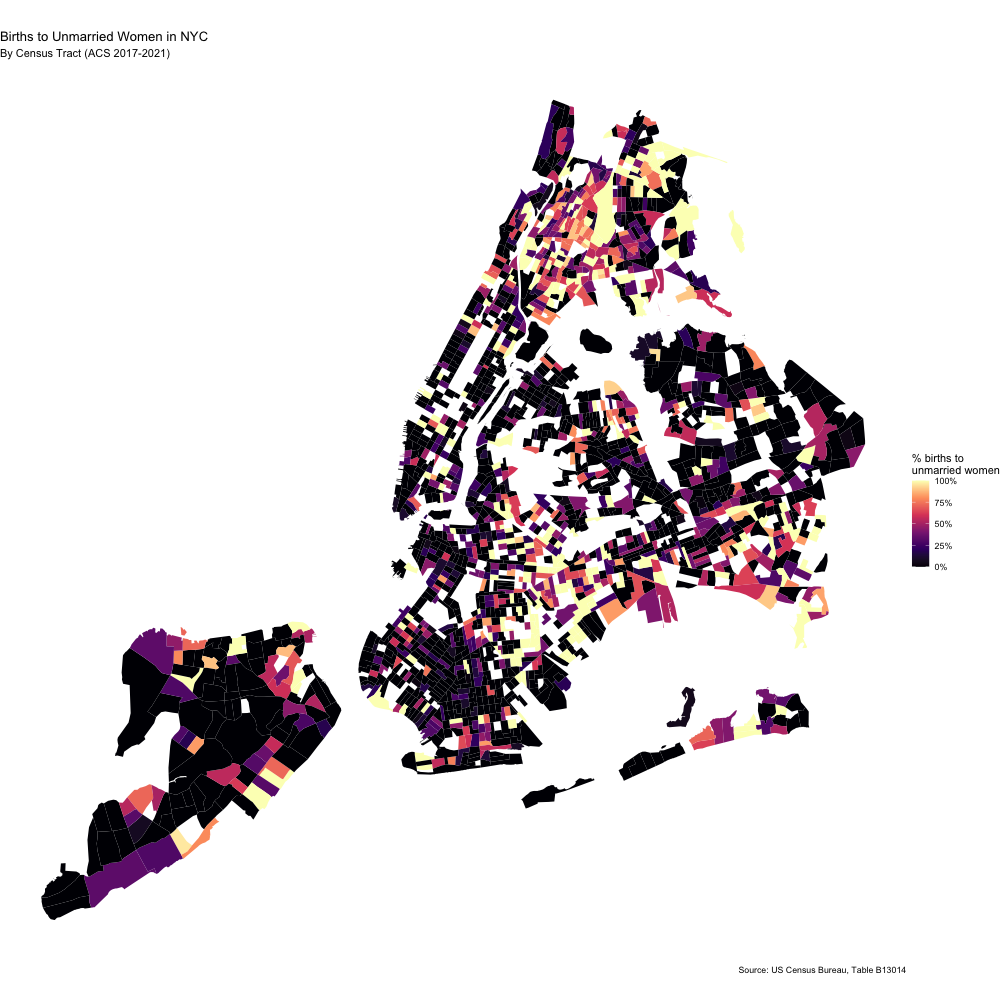

In [46]:
%%R -w 1000 -h 1000

# STEP 4: Map - Census Tract Level
#
# Using viridis "magma" color scale (yellow = high, dark purple = low)

library(scales)

ggplot(nyc_births_tract) +
  geom_sf(aes(fill = pct_unmarried), color = NA) +
  scale_fill_viridis_c(
    option = "magma",
    labels = function(x) paste0(round(x), "%"),
    name = "% births to\nunmarried women"
  ) +
  theme_void() +
  labs(
    title = "Births to Unmarried Women in NYC",
    subtitle = "By Census Tract (ACS 2017-2021)",
    caption = "Source: US Census Bureau, Table B13014"
  )

-  👉 Describe the output, what questions does this raise for you?

### Step 8b | Unmarried Births by County (Borough)

Comparing with a LARGER geography: NYC's 5 boroughs (counties).

**Why not block groups?** Table B13014 is not available at block group level - the Census Bureau doesn't publish this detailed demographic data at such fine granularity due to privacy/sample size concerns.

**Geography options for B13014:**
- ✅ State, County, Tract, PUMA, ZCTA
- ❌ Block Group, Block

In [47]:
%%R

# STEP 5: Fetch birth data at COUNTY level (NYC's 5 boroughs)
#
# NYC Borough = County mapping:
# - Manhattan = New York County
# - Brooklyn = Kings County  
# - Queens = Queens County
# - Bronx = Bronx County
# - Staten Island = Richmond County

nyc_births_county <- get_acs(
  geography = "county",
  state = "NY",
  county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
  variables = c(
    total_births = "B13014_002",
    unmarried_births = "B13014_009"
  ),
  year = 2021,
  survey = "acs5",
  geometry = TRUE,
  output = "wide"
)

# Add borough names for readability
nyc_births_county <- nyc_births_county %>%
  mutate(
    borough = case_when(
      str_detect(NAME, "New York") ~ "Manhattan",
      str_detect(NAME, "Kings") ~ "Brooklyn",
      str_detect(NAME, "Queens") ~ "Queens",
      str_detect(NAME, "Bronx") ~ "Bronx",
      str_detect(NAME, "Richmond") ~ "Staten Island"
    ),
    pct_unmarried = (unmarried_birthsE / total_birthsE) * 100
  )

# Show the data - should be just 5 rows
nyc_births_county %>%
  st_drop_geometry() %>%
  select(borough, total_birthsE, unmarried_birthsE, pct_unmarried)

  |======================================================================| 100%
    borough total_birthsE unmarried_birthsE pct_unmarried
1 Manhattan         15903              2916      18.33616
2 Manhattan         23755              5622      23.66660
3 Manhattan         32888              8039      24.44357
4 Manhattan          5546              1322      23.83700
5 Manhattan         21217             10554      49.74313


Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


In [48]:
%%R

# Remove water areas for cleaner map
nyc_births_county <- nyc_births_county %>% erase_water()

# Summary
cat("% Births to Unmarried Women by Borough:\n\n")
nyc_births_county %>%
  st_drop_geometry() %>%
  select(borough, pct_unmarried) %>%
  arrange(desc(pct_unmarried))

% Births to Unmarried Women by Borough:

    borough pct_unmarried
1 Manhattan      49.74313
2 Manhattan      24.44357
3 Manhattan      23.83700
4 Manhattan      23.66660
5 Manhattan      18.33616


Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In st_point_on_surface.sfc(sf::st_zm(x)) :  
R callback write-console: 
   
R callback write-console:  st_point_on_surface may not give correct results for longitude/latitude data
  


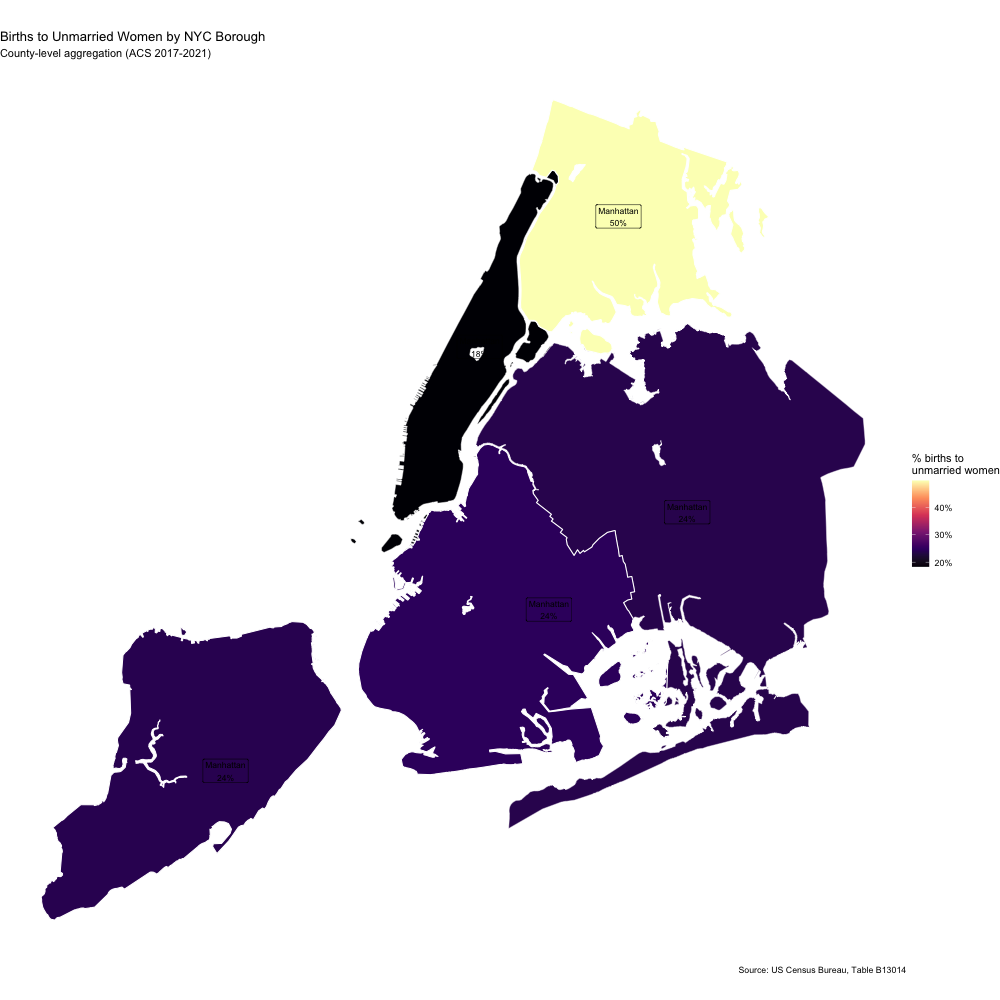

In [49]:
%%R -w 1000 -h 1000

# STEP 6: Map - County (Borough) Level
#
# This shows the overall pattern by borough
# Less detail than tract level, but clearer borough-level story

ggplot(nyc_births_county) +
  geom_sf(aes(fill = pct_unmarried), color = "white", size = 0.5) +
  geom_sf_label(aes(label = paste0(borough, "\n", round(pct_unmarried), "%")), 
                size = 3) +
  scale_fill_viridis_c(
    option = "magma",
    labels = function(x) paste0(round(x), "%"),
    name = "% births to\nunmarried women"
  ) +
  theme_void() +
  labs(
    title = "Births to Unmarried Women by NYC Borough",
    subtitle = "County-level aggregation (ACS 2017-2021)",
    caption = "Source: US Census Bureau, Table B13014"
  )

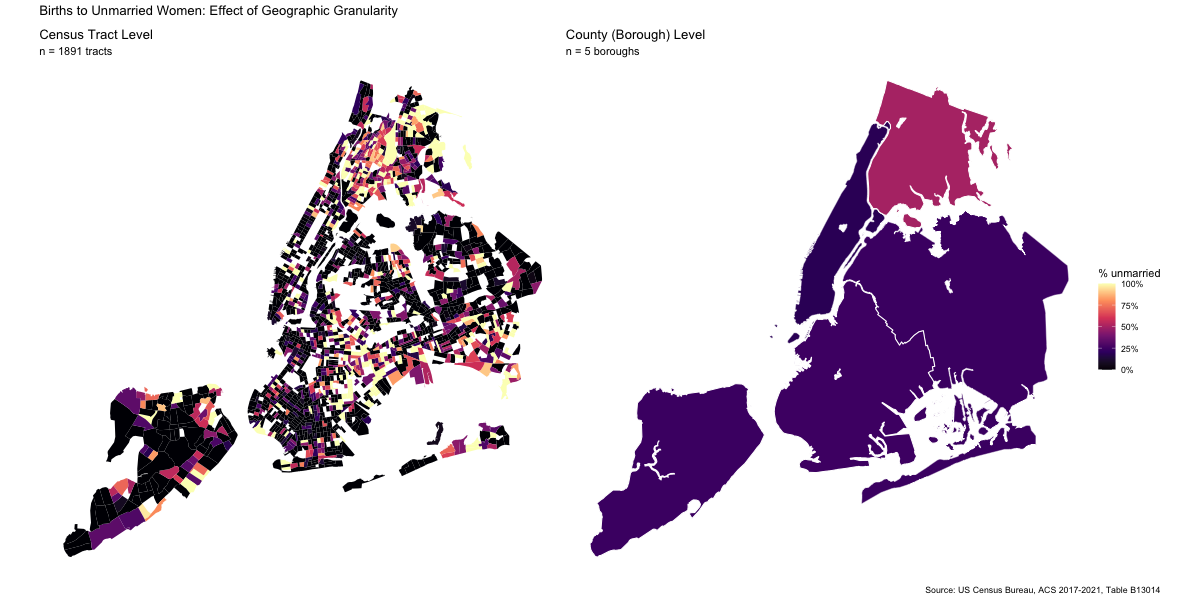

In [50]:
%%R -w 1200 -h 600

# STEP 7: Side-by-side comparison of both geography levels
#
# This shows how geographic granularity affects the story you can tell

library(patchwork)

# Tract-level map (detailed)
p1 <- ggplot(nyc_births_tract) +
  geom_sf(aes(fill = pct_unmarried), color = NA) +
  scale_fill_viridis_c(option = "magma", limits = c(0, 100),
                       labels = function(x) paste0(x, "%")) +
  theme_void() +
  labs(title = "Census Tract Level",
       subtitle = paste0("n = ", nrow(nyc_births_tract), " tracts")) +
  theme(legend.position = "none")

# County-level map (aggregated)
p2 <- ggplot(nyc_births_county) +
  geom_sf(aes(fill = pct_unmarried), color = "white", size = 0.5) +
  scale_fill_viridis_c(option = "magma", limits = c(0, 100),
                       labels = function(x) paste0(x, "%"),
                       name = "% unmarried") +
  theme_void() +
  labs(title = "County (Borough) Level",
       subtitle = "n = 5 boroughs")

# Combine
p1 + p2 + 
  plot_annotation(
    title = "Births to Unmarried Women: Effect of Geographic Granularity",
    caption = "Source: US Census Bureau, ACS 2017-2021, Table B13014"
  )

-  👉 Do your conclusions or questions change if you pick a different geography?

In [ ]:
# I think it does allow me to filter through the noise to understand that I should focus my story on Bronx county instead of spreading my attention thin on the many tracts with 100% or close to 100% unmarried births. The question will be why are there more unmarried mothers in Bronx over the past 12 months, and historically, whether the situation at the Bronx has improved or deterioriated.